# Imports

In [2]:
import numpy as np
import pandas as pd
import librosa as lb
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential, layers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

# READ THE DATA

In [3]:
metadata = pd.read_csv('./m_metadata.csv')
print(f'Samples num: {metadata.shape[0]}\nColumns num: {metadata.shape[1]}')
metadata.head()

Samples num: 216
Columns num: 3


,Sample,Class_ID,Class
0,./input/notes_v2/A/A1.wav,1,A
1,./input/notes_v2/A/A1.wav_000.wav,1,A
2,./input/notes_v2/A/A1.wav_010.wav,1,A
3,./input/notes_v2/A/A2.wav,1,A
4,./input/notes_v2/A/A2.wav_001.wav,1,A


# GETTING DATA ABOUT CLASSES

In [4]:
classes = metadata.groupby('Class_ID')['Class'].unique()
classes

Class_ID
1           [A]
2           [B]
3           [C]
4           [D]
5           [E]
6           [F]
7           [G]
8      [Barrel]
9       [Flage]
10    [PoffHon]
11       [Slap]
12      [Slide]
Name: Class, dtype: object

# CREATING A FUNCTION TO EXTRACT DATA FROM SAMPLES

In [5]:
def feature_exctractor(path: str) -> np.array:
    data, _ = lb.load(path)
    data = lb.feature.mfcc(data, n_mfcc=128)
    data= np.mean(data, axis=1)

    return data

# DATA EXTRACTION

In [6]:
x, y = [], []

for i, rows in tqdm(metadata.iterrows()):
    path = rows['Sample']
    x.append(feature_exctractor(path))
    y.append(rows['Class_ID'])

x = np.array(x)
y = np.array(y)

x.shape, y.shape

0it [00:00, ?it/s]C:\Users\arsal\AppData\Local\Temp\ipykernel_11932\2823641484.py:3: FutureWarning: Pass y=[ 0.00049936  0.00072294  0.00066204 ... -0.0020421  -0.00226114
 -0.00269657] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = lb.feature.mfcc(data, n_mfcc=128)
1it [00:02,  2.23s/it]C:\Users\arsal\AppData\Local\Temp\ipykernel_11932\2823641484.py:3: FutureWarning: Pass y=[ 0.00111869  0.00162757  0.00148511 ... -0.00458557 -0.00507908
 -0.00606102] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = lb.feature.mfcc(data, n_mfcc=128)
C:\Users\arsal\AppData\Local\Temp\ipykernel_11932\2823641484.py:3: FutureWarning: Pass y=[ 0.00044501  0.00064705  0.00058925 ... -0.02380368 -0.02216817
 -0.02099442] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = lb.feature.mfcc(data, n_mfcc=128)
3it [00:02,  1.58it/s]C:\Users\arsal

((216, 128), (216,))

# TRANSFER OF TARGET CLASSES TO CATEGORIAL TYPE

In [7]:
y = to_categorical(y)
y.shape

(216, 13)

# SPLITTING INTO TRAINING / TEST / VALIDATION DATA

In [8]:
xtrainval, xtest, ytrainval, ytest = train_test_split(x, y, test_size=0.1, stratify=y, random_state=42)
xtrain, xvalid, ytrain, yvalid = train_test_split(xtrainval, ytrainval, test_size=0.2, stratify=ytrainval,random_state=42)

print('\nNumber of samples for Train set :',xtrain.shape[0])
print('Number of samples for Validation set :',xvalid.shape[0])
print('Number of samples for Test set :',xtest.shape[0])


Number of samples for Train set : 155
Number of samples for Validation set : 39
Number of samples for Test set : 22


# MODEL ARCHITECTURE

In [9]:
model = Sequential(
    [
        layers.Dense(1000, activation='relu', input_shape=(128,)),
        layers.Dense(750, activation='relu'),
        layers.Dense(500, activation='relu'),
        layers.Dense(250, activation='relu'),
        layers.Dense(100, activation='relu'),
        layers.Dense(50, activation='relu'),
        layers.Dense(13, activation='softmax')
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000)              129000    
                                                                 
 dense_1 (Dense)             (None, 750)               750750    
                                                                 
 dense_2 (Dense)             (None, 500)               375500    
                                                                 
 dense_3 (Dense)             (None, 250)               125250    
                                                                 
 dense_4 (Dense)             (None, 100)               25100     
                                                                 
 dense_5 (Dense)             (None, 50)                5050      
                                                                 
 dense_6 (Dense)             (None, 13)                6

# MODEL COMPILATION AND TRAINING

In [18]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
training = model.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), epochs=20)

Epoch 1/20
5/5 [==============================] - 1s 45ms/step - loss: 1.8611e-04 - accuracy: 1.0000 - val_loss: 1.3075 - val_accuracy: 0.9231
Epoch 2/20
5/5 [==============================] - 0s 22ms/step - loss: 0.3041 - accuracy: 0.9677 - val_loss: 1.0747 - val_accuracy: 0.8462
Epoch 3/20
5/5 [==============================] - 0s 25ms/step - loss: 0.0401 - accuracy: 0.9806 - val_loss: 1.0152 - val_accuracy: 0.8462
Epoch 4/20
5/5 [==============================] - 0s 24ms/step - loss: 0.1760 - accuracy: 0.9548 - val_loss: 0.7302 - val_accuracy: 0.9231
Epoch 5/20
5/5 [==============================] - 0s 25ms/step - loss: 0.0435 - accuracy: 0.9742 - val_loss: 1.0324 - val_accuracy: 0.8718
Epoch 6/20
5/5 [==============================] - 0s 22ms/step - loss: 0.0082 - accuracy: 1.0000 - val_loss: 1.2461 - val_accuracy: 0.8205
Epoch 7/20
5/5 [==============================] - 0s 25ms/step - loss: 0.0449 - accuracy: 0.9935 - val_loss: 1.4345 - val_accuracy: 0.8462
Epoch 8/20
5/5 [=======

# VERIFICATION OF THE MODEL RESULTS

In [19]:
train_hist = pd.DataFrame(training.history)
train_hist

,loss,accuracy,val_loss,val_accuracy
0,0.000186,1.000000,1.307491,0.923077
1,0.304064,0.967742,1.074713,0.846154
2,0.040120,0.980645,1.015196,0.846154
3,0.175956,0.954839,0.730150,0.923077
4,0.043483,0.974194,1.032434,0.871795
5,0.008235,1.000000,1.246144,0.820513
6,0.044858,0.993548,1.434456,0.846154
7,0.110124,0.974194,1.070668,0.871795
8,0.062655,0.974194,0.535787,0.897436
9,0.051653,0.993548,1.227930,0.820513


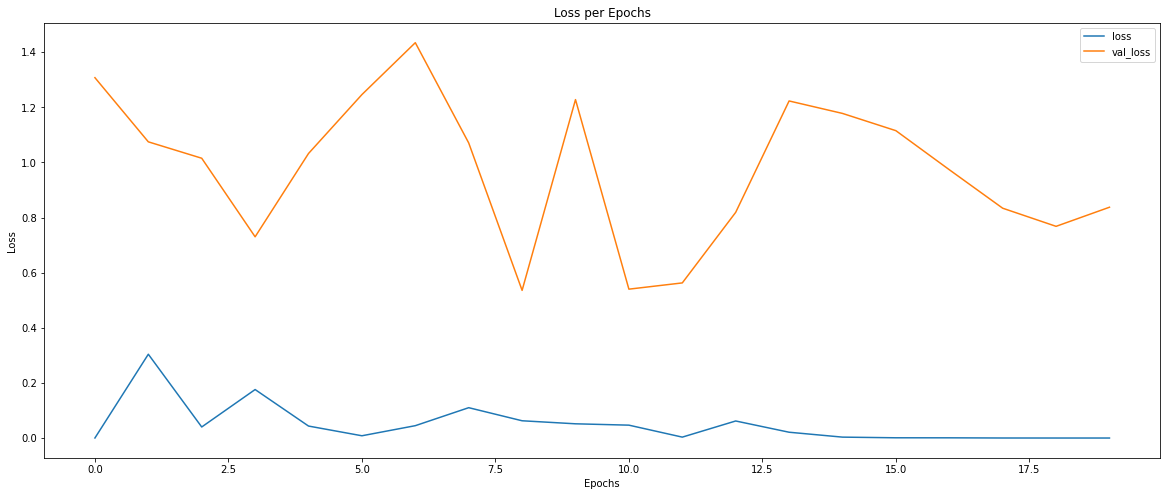

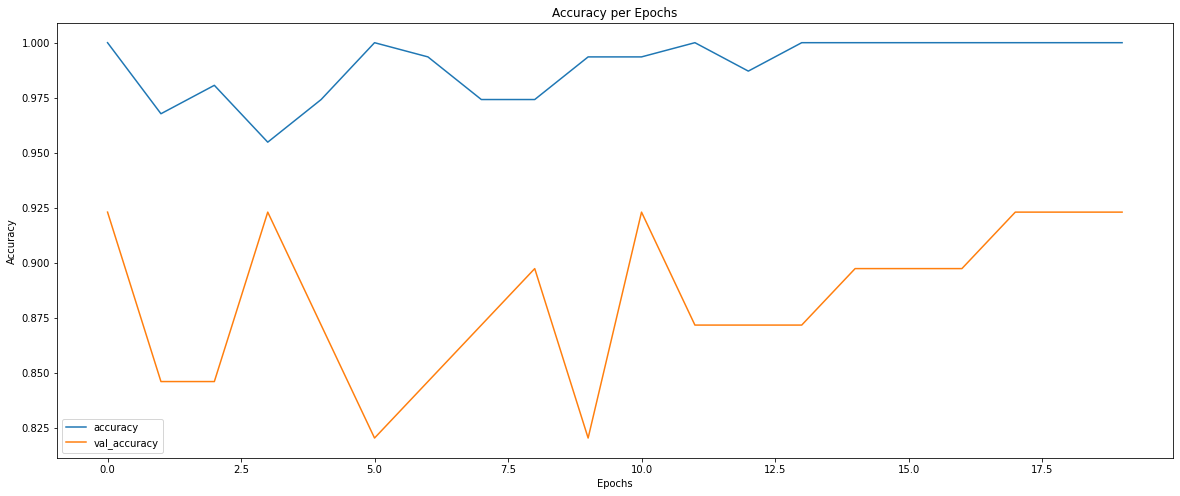

In [20]:
plt.figure(figsize=(20, 8))
plt.plot(train_hist[['loss', 'val_loss']])
plt.legend(['loss', 'val_loss'])
plt.title('Loss per Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(20, 8))
plt.plot(train_hist[['accuracy', 'val_accuracy']])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('Accuracy per Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [21]:
ytrue = np.argmax(ytest, axis=1)
ypred = np.argmax(model.predict(xtest), axis=1)
print('\nConfusion Matrix: \n\n')
print(confusion_matrix(ytrue, ypred))
print('\n\nClassification Report: \n\n', classification_report(ytrue, ypred))



Confusion Matrix: 


[[2 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0]
 [0 0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 0 0 2]]


Classification Report: 

               precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2
           8       1.00      0.50      0.67         2
           9       1.00      1.00      1.00         1
          10       0.67      1.00      0.80         2
          11       1.00      1

In [40]:
import os 
import tensorflow as tf 
from tensorflow import keras 

print(tf.version.VERSION)

2.8.0


In [41]:
model.save('./model')

INFO:tensorflow:Assets written to: ./model\assets
